# Step 0: Load The Data

In [89]:
# Load pickled data
import pickle
import csv
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import tensorflow as tf

training_file = './train.p'
validation_file= './valid.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Step1: Dataset Summary & Exploration

In [108]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_valid = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print('Number of training examples =', n_train)
print('Number of testing examples =', n_test)
print('Number of validation examples =', n_valid)
print('Image data shape =', image_shape)
print('Number of classes =', n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


#Visualization of the dataset

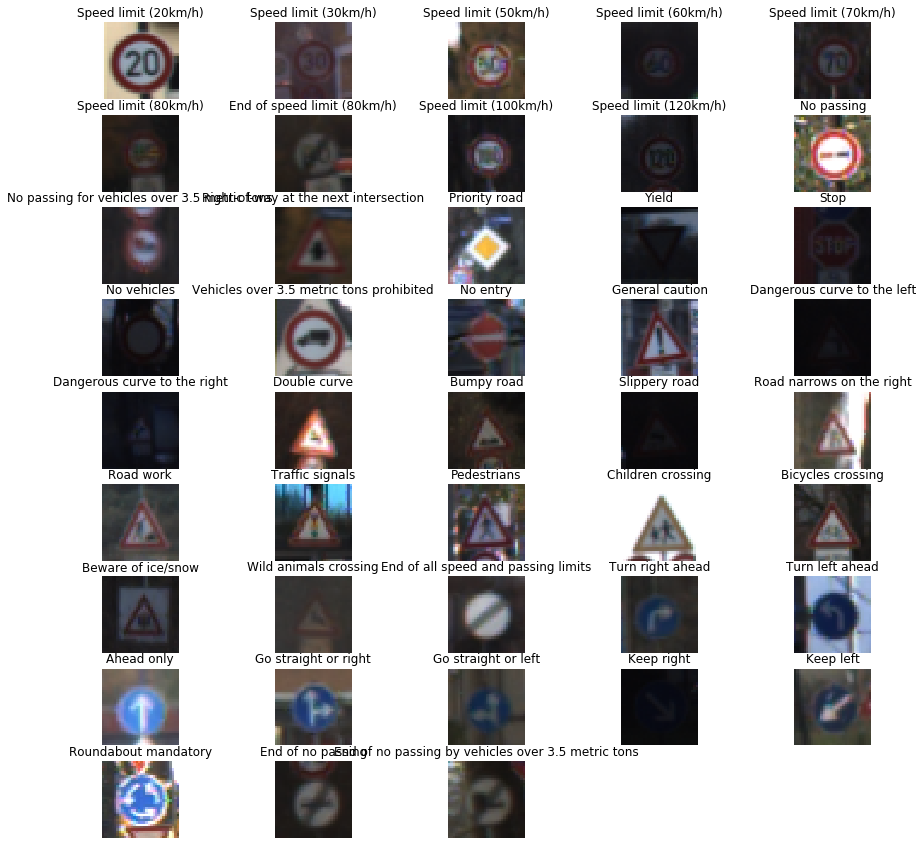

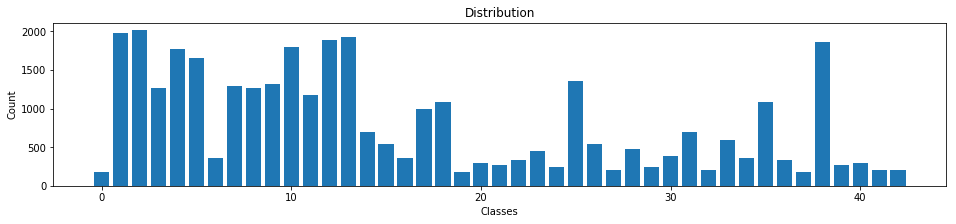

In [91]:
%matplotlib inline
label2Name = {}
with open('./signnames.csv') as namesFile:
    nameReader = csv.reader(namesFile)
    for row in nameReader:
        label2Name[int(row[0])] = row[1]

num_of_imgs=[]
plt.figure(figsize=(15, 15))
for i in range(n_classes):    
    img_class = X_train[y_train == i]
    plt.subplot(9, 5, i+1)
    plt.imshow(img_class[0, :, :, :])
    plt.title(label2Name[i])
    plt.axis('off')
    num_of_imgs.append(len(img_class))

#Plot distribution of classes
plt.figure(figsize=(16, 3))
plt.bar(range(0, n_classes), num_of_imgs)
plt.title('Distribution')
plt.xlabel(Classes')
plt.ylabel('Count')
plt.show()

# Step 2: Design and Test a Model Architecture

#Pre-process the Data Set (normalization, grayscale, etc.)

In [107]:
def preprocess(image):
    output = np.zeros(image_shape, np.float64)
    output = (image.astype(np.float64) - 128)/128
    return output

processed_train = np.zeros(X_train.shape, np.float64)
for i in range(n_train):
    processed_train[i] = preprocess(X_train[i])

processed_valid = np.zeros(X_valid.shape, np.float64)
for i in range(n_valid):
    processed_valid[i] = preprocess(X_valid[i])

processed_test = np.zeros(X_test.shape, np.float64)
for i in range(n_test):
    processed_test[i] = preprocess(X_test[i])

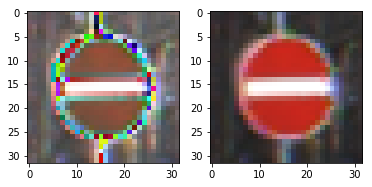

In [106]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(processed_test[200,:,:,:])
plt.subplot(1, 2, 2)
plt.imshow(X_test[200,:,:,:])

#Model Architecture

In [28]:
from tensorflow.contrib.layers import flatten

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

def LeNet(x, mu = 0, sigma = 0.1): 

    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x16. Output = 14x14x16.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Input = 14x14x16. Output = 10x10x64. 
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x64. Output = 5x5x64.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x64. Output = 1600.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 1600. Output = 240.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1600, 240), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(240))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b    
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout
    fc1    = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 240. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(240, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
                        
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return (logits, conv1, conv2, fc1, fc2)

#Train, Validate and Test the Model

In [10]:
rate = 0.001
EPOCHS = 40
BATCH_SIZE = 128
sess_save_file = './sessfile'

logits, conv1, conv2, fc1, fc2 = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(x_eva, y_eva):
    num_samples = len(x_eva)
    final_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_samples, BATCH_SIZE):
        batch_x, batch_y = x_eva[offset : offset + BATCH_SIZE], y_eva[offset : offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        final_accuracy += (accuracy * len(batch_x))
    final_accuracy = final_accuracy / num_samples
    return final_accuracy

epoch_validation = np.zeros((EPOCHS), dtype=np.float64)
test_accuracy = 0.0
time_on = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_samples = n_train
    validat_accuracy = 0.0
    print('Training...')
    for i in range(EPOCHS):
        print('EPOCH ', i+1)
        for offset in range(0, num_samples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = processed_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.6})

        validation_accuracy = evaluate(processed_valid, y_valid)
        epoch_validation[i] = validation_accuracy
        print('Accuracy-Validation: {:.3f}'.format(validation_accuracy))

    train_accuracy = evaluate(processed_train, y_train)
    test_accuracy = evaluate(processed_test, y_test)
    print('Finished!')
    print('Accuracy -- Train: {:.3f}, Validation: {:.3f}, Test: {:.3f}'.format(train_accuracy, validation_accuracy, test_accuracy))
    saver.save(sess, sess_save_file)
time_off=time.time()
print('Time used: ', time_off-time_on)

Training...


KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(ncols=1, figsize=(5, 4))
axes.plot(range(1, EPOCHS + 1), epoch_validation)
axes.set_xlabel('Epochs')
axes.set_ylabel('Accuracy')
axes.grid(True)

# Step 3: Test a Model on New Images

#Load and Output the Images

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import glob
import matplotlib.image as mpimg

webImagesDir = 'webimages'
imageNames = glob.glob('webimages/*.jpg')
webImages = [ mpimg.imread('./' + imgName ) for imgName in imageNames ]

fig, axes = plt.subplots(ncols=len(webImages), figsize=(16, 8))
for ax, image, imageName in zip(axes, webImages, imageNames):
    ax.imshow(image)
    ax.set_title(imageName)
    
# Pre-processing
X_web = preprocessing(webImages)
fig, axes = plt.subplots(ncols=len(webImages), figsize=(16, 8))
for ax, image, imageName in zip(axes, X_web, imageNames):
    ax.imshow(image)
    ax.set_title(imageName)
    
with tf.Session() as sess:
    saver.restore(sess, sess_save_file)
    web_classes = sess.run(logits, feed_dict={x: X_web, keep_prob : 1.0})
    web_softmax = sess.run(tf.nn.softmax(logits), feed_dict={x: X_web, keep_prob : 1.0})
    
def plotOutput(classes, names):
    """
    Plot the network output
    """
    nCols = len(classes)
    assert(nCols == len(names))
    
    fig, axes = plt.subplots(ncols=nCols, figsize=(4*nCols, 4))
    for ax, aClass, title in zip(axes, classes, names):        
        ax.bar(range(0,43), aClass)
        ax.set_xlabel('Hist')
        ax.set_ylabel('Count')
        ax.set_title(title)
        ax.grid(True)
        
    fig.tight_layout()
    plt.show()

plotOutput(web_classes, imageNames)

with tf.Session() as sess:
    predicts = sess.run(tf.nn.top_k(web_softmax, k=5, sorted=True))
namedPredictions = [ label2Name[predicts[1][i][0]] for i in range(0, len(imageNames))]

fig, axes = plt.subplots(ncols=len(webImages), figsize=(16, 8))
for ax, image, imageName, predictedName in zip(axes, webImages, imageNames, namedPredictions):
    index = predicts[1][1]
    ax.imshow(image)
    ax.set_title('{} \n {}'.format(imageName, predictedName))

# Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [ ]:
for i in range(len(predicts[0])):
    print('Image: ' + imageNames[i])
    print('Probabilities:')
    for j in range(0, len(predicts[0][i])):
        prob = predicts[0][i][j]
        index = predicts[1][i][j]
        name = label2Name[index]
        print('   {:.6f} : {} - {}'.format(prob, index, name))
    print()

# Step 4 (Optional): Visualize the Neural Network's State with Test Images

In [ ]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    if featuremaps > 48:
        featuremaps = 48
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

with tf.Session() as sess:
    saver.restore(sess, sess_save_file)
    print("conv1 : First layer")
    outputFeatureMap(X_web, conv1)   
    saver.restore(sess, sess_save_file)    
    web_classes = sess.run(logits, feed_dict={x: X_web, keep_prob : 1.0})
    print("conv2 : Second layer")
    outputFeatureMap(X_web, conv2)